<a href="https://colab.research.google.com/github/a-donat/Data-Science-Portfolio/blob/master/Detecting_Fake_Pokemon_Cards_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Detecting Fake Pokemon Cards with a Convolutional Neural Network**<br>
by Annalisa Donat

Overview: Pokemon cards are considered a collectors' item and a single card can be sold for thousands of dollars [(see live prices here)](https://www.pokemonwizard.com/), and thus there is propensity for fraud. Signs of fraud are not visible to the naked eye (at least not to mine), but I was able to train a Convolutional Neural Network to detect fake cards with an **accuracy of 97.44% on unseen data**. I am particularly proud of my ability to look at the images and see which types of distortion would prevent overfitting (shearing images) and which types would simply cause a loss of important information (flipping and zooming).



# I. Set Up

## I.A. Import Libraries

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## I.B. Download Data from Kaggle

https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

In [ ]:
! pip install kaggle


**don't forget to upload Kaggle credentials in json format**

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

**get command from Kaggle:**

In [4]:
!kaggle datasets download -d ongshujian/real-and-fake-pokemon-cards

 64% 7.00M/11.0M [00:00<00:00, 13.4MB/s]
100% 11.0M/11.0M [00:00<00:00, 13.3MB/s]


**unzip if necessary:**

In [ ]:
!unzip '/content/real-and-fake-pokemon-cards.zip' -d '/content/pokemon_cards'


# II. Data Preparation

In [6]:
# list categories in string format
categories = ["Real", "Fake"]

In [7]:
raw_data_dir = "/content/pokemon_cards/"

## II.A. Sort Observations into Folders by Class

In [8]:
import shutil

In [9]:
train_labels_path = "/content/pokemon_cards/train_labels.csv"
test_labels_path = "/content/pokemon_cards/test_labels.csv"

In [10]:
train_labels_df = pd.read_csv(train_labels_path)
test_labels_df = pd.read_csv(test_labels_path)

In [11]:
os.mkdir(raw_data_dir + "train/Real")
os.mkdir(raw_data_dir + "train/Fake")
os.mkdir(raw_data_dir + "test/Real")
os.mkdir(raw_data_dir + "test/Fake")

In [12]:
train_labels_df["id"] = train_labels_df["id"].astype(str) + ".JPG"
test_labels_df["id"] = test_labels_df["id"].astype(str) + ".JPG"

In [13]:
print(
    train_labels_df["label"].mean() * 100, "% of cards in training set are real")

67.02412868632707 % of cards in training set are real


In [14]:
def move_to_labeled_folder(filenames, main_folder, label):
  if main_folder[-1] != "/":
    main_folder = main_folder + "/"
  if label[-1] != "/":
    label = label + "/"
  for fn in filenames:
    shutil.move(raw_data_dir + main_folder + fn, 
                raw_data_dir + main_folder + label + fn)

In [15]:
move_to_labeled_folder(
    train_labels_df[train_labels_df["label"] == 1]["id"].tolist(), 
    "train", "Real")

In [16]:
move_to_labeled_folder(
    train_labels_df[train_labels_df["label"] == 0]["id"].tolist(), 
    "train", "Fake")

In [17]:
move_to_labeled_folder(
    test_labels_df[test_labels_df["label"] == 1]["id"].tolist(), 
    "test", "Real")
move_to_labeled_folder(
    test_labels_df[test_labels_df["label"] == 0]["id"].tolist(), 
    "test", "Fake")

## I.B. Separate Data into Training, Validation, and Test Sets

In [18]:
os.mkdir(raw_data_dir + "val")
os.mkdir(raw_data_dir + "val/Real")
os.mkdir(raw_data_dir + "val/Fake")

In [19]:
import random


In [23]:
random.seed(0)

n_real = train_labels_df[train_labels_df["label"] == 1].shape[0]
n_fake = train_labels_df[train_labels_df["label"] == 0].shape[0]

real_val_inds = random.sample(range(n_real), int(n_real * 0.25))
fake_val_inds = random.sample(range(n_fake), int(n_fake * 0.25))

In [25]:
val_fake_fns = train_labels_df[train_labels_df["label"] == 0
                          ]["id"].iloc[fake_val_inds].tolist()

val_real_fns = train_labels_df[train_labels_df["label"] == 1
                          ]["id"].iloc[real_val_inds].tolist()

for fn in val_real_fns:
    shutil.move(raw_data_dir + "train/Real/" + fn, 
                raw_data_dir + "val/Real/" + fn)

for fn in val_fake_fns:
    shutil.move(raw_data_dir + "train/Fake/" + fn, 
                raw_data_dir + "val/Fake/" + fn)

In [27]:
sorted_dir = raw_data_dir

In [28]:
train_folder = sorted_dir + "train/"

print("Samples in Training Set Per Category")
for c in categories:
  print(c, len([x for x in os.listdir(train_folder + c)]))

Samples in Training Set Per Category
Real 188
Fake 93


# III. Data Exploration and Visualization

In [29]:
def get_info(cat_name, file_path):
  img = Image.open(file_path)
  return [file_path, cat_name, img.width, img.height]

sizes = [
    get_info(c, train_folder + c + "/" + fn) 
    for c in categories
    for fn in os.listdir(train_folder + c) ]

sizes_df = pd.DataFrame(
    sizes, columns=["filepath", "category", "width", "height"])

In [30]:
sizes_df.head()

,filepath,category,width,height
0,/content/pokemon_cards/train/Real/163.JPG,Real,256,256
1,/content/pokemon_cards/train/Real/293.JPG,Real,256,256
2,/content/pokemon_cards/train/Real/262.JPG,Real,256,256
3,/content/pokemon_cards/train/Real/160.JPG,Real,256,256
4,/content/pokemon_cards/train/Real/170.JPG,Real,256,256


In [31]:
sizes_df.nunique()

filepath    281
category      2
width         1
height        1
dtype: int64

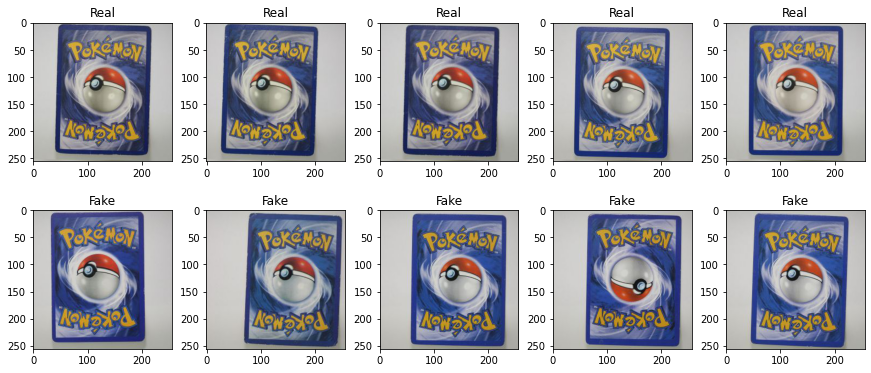

In [32]:
sample_paths = [
    sizes_df[sizes_df["category"] == c
    ]["filepath"].iloc[[6, 24, 43, 63, 75]].tolist()
    for c in categories]
sample_paths = [x for y in sample_paths for x in y]

n_cats = len(categories)
fig, axes = plt.subplots(figsize=(15, 3*n_cats), nrows=n_cats, ncols=5)
plt.subplots_adjust(hspace=0.35)

for r in range(n_cats):
  for c in range(5):
    img = mpimg.imread(sample_paths[r * 5 + c])
    axes[r][c].imshow(img, cmap="gray")
    axes[r][c].set_title(categories[r])
plt.show()

Looking at these images, I feel that zooming or flipping an image could result in a loss of important information, and thus I will use shearing (x-axis distortion) to generate a training set that will not lead to overfitting.

In [33]:
# check scale of raw file (typically 0 to 255)
np.array(Image.open(sizes_df["filepath"].iloc[0])).max()

249

# IV. Data Preprocessing & Augmentation

In [34]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.05
        )

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        sorted_dir + "train",
        target_size=(150, 150),
        batch_size=32,
        class_mode="categorical")

validation_generator = train_datagen.flow_from_directory(
        sorted_dir + "val",
        target_size=(150, 150),
        batch_size=32,
        class_mode="categorical")

test_generator = test_datagen.flow_from_directory(
        sorted_dir + "test",
        target_size=(150, 150),
        batch_size=32,
        shuffle = False,
        class_mode="categorical")

Found 281 images belonging to 2 classes.
Found 92 images belonging to 2 classes.
Found 78 images belonging to 2 classes.


In [35]:
train_generator.class_indices

{'Fake': 0, 'Real': 1}

In [36]:
train_generator.image_shape

(150, 150, 3)

# V. Build Convolutional Neural Network Model

In [37]:
model = Sequential()
# add the convolutional layer
# filters, size of filters,padding,activation_function,input_shape
model.add(Conv2D(32, (5, 5), padding="SAME", activation="relu", 
                 input_shape=(150, 150, 3)))
# pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))
# place a dropout layer
model.add(Dropout(0.5))

# add another convolutional layer
model.add(Conv2D(64, (5, 5), padding="SAME", activation="relu"))
# pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# place a dropout layer
model.add(Dropout(0.5))

# Flatten layer
model.add(Flatten())
# add a dense layer : amount of nodes, activation
model.add(Dense(256, activation="relu"))
# place a dropout layer
# 0.5 drop out rate is recommended, half input nodes will be dropped at each update
model.add(Dropout(0.5))
model.add(Dense(n_cats, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 75, 75, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 37, 37, 64)        0

# VI. Compile & Train the Model

In [38]:
# compile the model
model.compile(
    Adam(lr=0.001), loss="binary_crossentropy", metrics=["accuracy"])


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [39]:
#train the model
history = model.fit(train_generator, 
                    epochs=30, 
                    validation_data=validation_generator)

Epoch 1/30
9/9 [==============================] - 11s 305ms/step - loss: 1.9946 - accuracy: 0.5907 - val_loss: 0.6926 - val_accuracy: 0.6739
Epoch 2/30
9/9 [==============================] - 2s 254ms/step - loss: 0.6563 - accuracy: 0.6690 - val_loss: 0.6883 - val_accuracy: 0.6739
Epoch 3/30
9/9 [==============================] - 2s 254ms/step - loss: 0.6257 - accuracy: 0.6690 - val_loss: 0.6877 - val_accuracy: 0.6630
Epoch 4/30
9/9 [==============================] - 3s 342ms/step - loss: 0.5928 - accuracy: 0.6619 - val_loss: 0.6817 - val_accuracy: 0.6196
Epoch 5/30
9/9 [==============================] - 2s 256ms/step - loss: 0.5461 - accuracy: 0.7544 - val_loss: 0.6116 - val_accuracy: 0.6957
Epoch 6/30
9/9 [==============================] - 2s 260ms/step - loss: 0.4854 - accuracy: 0.7865 - val_loss: 0.5711 - val_accuracy: 0.7391
Epoch 7/30
9/9 [==============================] - 2s 258ms/step - loss: 0.4502 - accuracy: 0.7936 - val_loss: 0.5834 - val_accuracy: 0.7609
Epoch 8/30
9/9 [===

# VII. Performance Evaluation


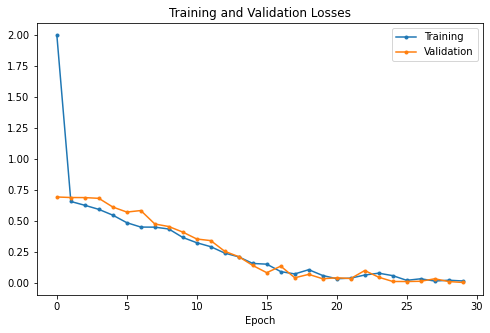

In [40]:
#plot graph between training and validation loss
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(history.history["loss"], marker=".")
ax.plot(history.history["val_loss"], marker = ".")
ax.legend(["Training", "Validation"])
ax.set_title("Training and Validation Losses")
ax.set_xlabel("Epoch")
plt.show()

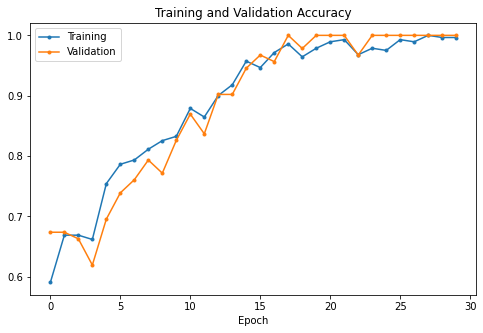

In [41]:
#plot graph between training and validation accuracy
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(history.history["accuracy"], marker=".")
ax.plot(history.history["val_accuracy"], marker = ".")
ax.legend(["Training", "Validation"])
ax.set_title("Training and Validation Accuracy")
ax.set_xlabel("Epoch")
plt.show()

In [42]:
# get the test acuarcy and loss
test_loss, test_acc = model.evaluate(test_generator)
print("test loss :{} test acc :{}".format(test_loss, test_acc))

3/3 [==============================] - 0s 114ms/step - loss: 0.1206 - accuracy: 0.9744
test loss :0.12062252312898636 test acc :0.9743589758872986


**Achieved accuracy of 97.44%**